Este documento es propiedad el **Equipo 7** y corresponde a la entrega *Solución del Reto* del curso TC3006C. Nuestro equipo esta conformado por:

* Rodolfo Sandoval Schipper A01720253
* Marcelo Márquez A01720588
* Arturo Garza Campuzano A00828096

# Selección, configuración y entrenamiento del modelo

## Importar módulos

In [296]:
# Uso general
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Division de subconjuntos y escalamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modelo
from sklearn.neighbors import KNeighborsClassifier

# Metricas
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

## Cargar datos

In [297]:
# Este bloque de codigo no es necesario si el archivo esta guardado localmente
from google.colab import drive
drive.mount('/content/drive')

# Cambiar ruteo con de acuerdo a la ubicacion los archivos en su dispositivo
train_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Solucion/train_etl.csv')
test_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Solucion/test_etl.csv')

#Descripcion de datos de entrenamiento
cantidad_registros = len(train_df)
numero_caracteristicas = len(train_df.columns) - 1
valores_salida = train_df["Survived"].unique()
print("Descripcion de Training ETL Titanic Dataset")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Número de características: {numero_caracteristicas}")
print(f"Valores de salida: {valores_salida}")

#Descripcion de datos de prueba
cantidad_registros = len(test_df)
numero_caracteristicas = len(test_df.columns) - 1
print("Descripcion de Testing ETL Titanic Dataset")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Número de características: {numero_caracteristicas}")
print(f"Valores de salida: Ninguno.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Descripcion de Training ETL Titanic Dataset
Cantidad de registros: 891
Número de características: 7
Valores de salida: [0 1]
Descripcion de Testing ETL Titanic Dataset
Cantidad de registros: 418
Número de características: 7
Valores de salida: Ninguno.


## Separación de datos en subconjuntos

Para entrenar al modelo se dividen los datos en los subconjuntos de entrenamiento y vaidación en una proporción de sesenta y cuarenta respectivamente. Para realizar este división se utiliza la función **train_test_split**, la cual selecciona las muestras para cada subconjunto aleaoriamente.

In [298]:
# Seleccion de columnas de train_df
n = len(train_df.columns) - 1
X = train_df.iloc[:, 0:n]
y = train_df.iloc[:, n]

# Dividir el dataset en conjuntos de entrenamiento (60%) y validacion (40%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

## Random Forest Classifier

Dentro de este codigo se incorpora una solucion para crear un modelo tipo Random Forest para predecir si un pasajero sobrevive o no. A continuacion se explica el proceso por medio de comentarios y estrucutra de codigo para eficientar el aprendizaje del modelo y sus caracterisicas. La razon por la que se escogio este dataset fue por el motivo de que ya tenemos el ETL para analizar los datos de forma mas organizada y asi llevar a tener mejores resultados. Los datos transformados se encuentran en el archivo train_etl y test_etl. Usaremos esta informacion para alimentar el modelo y finalmente usaremos tests para probarlo.

La referencia para hacer este modelo se compoarte en la siguiente liga: https://machinelearningmastery.com/implement-random-forest-scratch-python/

Liga del dataset (No incluye el proceso de ETL): https://www.kaggle.com/competitions/titanic

Nota: En caso de correr el codigo localmente asegurarse de tener el ruteo y la direccion correta de los archivos train_etl.csv y test_etl.csv.

Vamos a estar usando varios decision trees. El objetivo es combinarlos y agregar las predicciones para tomar una decision final.

Este modelo fue realizado por: Rodolfo Sandoval, miembro del equipo 7 del curso TC3006C.101.

### Entrenamiento del modelo

In [299]:
# Funcion para calcular la impureza Gini
def gini_impureza(etiquetas):
    clases_unicas, counts = np.unique(etiquetas, return_counts=True) #Encontramos las clases unicas
    clases_prob = counts / len(etiquetas) #Calculamos las probabilidades de las clases en relacion a la longitud total de etiquetas
    gini = 1 - np.sum(clases_prob ** 2) #Calculamos la impuresa de Gini (con esto determinamos como dividir los datos en los nodos del arbol)
    return gini

# Funcion para dividir los datos en funcion de un valor de umbral data = datos, feature_idx = indice donde se basa la division, y umbral = el valor umbral que se realiza para la division
def split_data(data, feature_idx, umbral):
    izq = data[data[:, feature_idx] <= umbral] #subconjunto con los valores sean menor o iguales al umbral
    derecha = data[data[:, feature_idx] > umbral] #subconjunto cuando sean mayores al umbral
    return izq, derecha

# Funcion para encontrar la mejor division para un conjunto de datos
def find_best_split(data):
    best_gini = float("inf") # Inicializar con un valor alto para comparacion
    best_feature_idx = None
    best_umbral = None

    num_features = data.shape[1] - 1 #Restamos la columna que incluye etiquetas

#Iteramos sobre las caracteristicas
    for feature_idx in range(num_features):
        unique_values = np.unique(data[:, feature_idx])
        for umbral in unique_values: #Sobre valores unicos
            izq, derecha = split_data(data, feature_idx, umbral)
            if len(izq) > 0 and len(derecha) > 0: # Dividir los datos en dos subconjuntos: izquierdo y derecho
                gini_izq = gini_impureza(izq[:, -1]) #Calcular impureza gini para lado izquierdo
                gini_derecha = gini_impureza(derecha[:, -1]) #Calcular impureza gini para lado derecho
                weighted_gini = (len(izq) / len(data)) * gini_izq + (len(derecha) / len(data)) * gini_derecha #Caclular la impureza despues de la division

                if weighted_gini < best_gini: #Checar si se encuentra una mejor division y replazar esos valores
                    best_gini = weighted_gini
                    best_feature_idx = feature_idx
                    best_umbral = umbral

    return best_feature_idx, best_umbral

# Funcion para construir un arbol de decision
def build_tree(data, max_depth):
    if max_depth == 0 or len(np.unique(data[:, -1])) == 1: #Checar si max_depth (profundidad de los nodos) es 0 o sin las etiquetas son iguales con unique
        clases_unicas, counts = np.unique(data[:, -1], return_counts=True)
        return clases_unicas[np.argmax(counts)]

    best_feature_idx, best_umbral = find_best_split(data)

    # Sacar la clase mayoritaria en caso de que no sea posible hacer una division (Clase con mayor cantidad de ejemplos)
    if best_feature_idx is None:
        clases_unicas, counts = np.unique(data[:, -1], return_counts=True)
        return clases_unicas[np.argmax(counts)]

    # Dividir los datos en dos subconjuntos usando la mejor caracteristica y umbral
    izq, derecha = split_data(data, best_feature_idx, best_umbral)
    izq_subtree = build_tree(izq, max_depth - 1)
    derecha_subtree = build_tree(derecha, max_depth - 1)
    return (best_feature_idx, best_umbral, izq_subtree, derecha_subtree) #Retornamos un nodo arbol con la mejor caracteristica

# Funcion para construir un Random Forest
def build_random_forest(data, num_arboles, max_depth):
    forest = [] #Lista de los arboles del bosque
    for _ in range(num_arboles):
        subset = np.random.choice(len(data), size=len(data), replace=True) #Creamos subconjunto aleatorio con replace para el conjunto de datos
        subset_data = data[subset]
        tree = build_tree(subset_data, max_depth) #Contruimos un arbol aleatorio
        forest.append(tree) #Agregamos el arbol al bosque
    return forest

# Funcion para hacer predicciones usando un arbol de decision
def predict(tree, sample):
    if isinstance(tree, np.int64):  # Si el nodo actual es una clase, devuelve la clase predicha
        return tree

    feature_idx, umbral, izq_subtree, derecha_subtree = tree

    if sample[feature_idx] <= umbral: # Comparamos el valor de la caracteristica (feature_idx) de la muestra con el umbral
        return predict(izq_subtree, sample) #Si es menor o igual al umbral nos vamos por el subarbol izq
    else:
        return predict(derecha_subtree, sample) #Si mayor al umbral nos vamos por el subarbol derecho

# Funcion para hacer predicciones con el Random Forest
def predict_random_forest(forest, sample):
    predi = [predict(tree, sample) for tree in forest]
    return np.bincount(predi).argmax()

train_data = np.column_stack((X_train, y_train))
validation_data = np.column_stack((X_val, y_val))

# Convertir los conjuntos X_train y y_train a arreglos NumPy para facilitar su manejo
train_data = np.column_stack((X_train, y_train))
num_arboles = 100
max_depth = 3
forest = build_random_forest(train_data, num_arboles, max_depth)


### Análisis de desempeño

#### Métricas de desempeño para subconjuntos de entrenamiento y validación

Para evaluar el desempeño del **clasificador de bosque aleatorio** se prueba con los subconjuntos de entrenamiento y validación para obtener las predicciones. Después se calculan las métricas de desempeño considerando las predicciones de cada subconjunto y los valores esperados.

In [300]:
# Hacer predicciones en datos de validacion
y_pred_val = [predict_random_forest(forest, sample) for sample in validation_data[:, :-1]]
actual_etiquetas_val = validation_data[:, -1]

# Hacer predicciones en datos de entrenamiento
y_pred_train = [predict_random_forest(forest, sample) for sample in train_data[:, :-1]]
actual_etiquetas_train = train_data[:, -1]

def metricas_desempeno(y, y_pred):
  confusion_matrix_results = confusion_matrix(y, y_pred)
  accuracy_score_results = accuracy_score(y, y_pred)
  precision_score_results = precision_score(y, y_pred)
  recall_score_results = recall_score(y, y_pred)
  f1_score_results = f1_score(y, y_pred)
  return confusion_matrix_results, accuracy_score_results, precision_score_results, recall_score_results, f1_score_results

# Metricas de desempeno para subconjunto de entrenamiento
confusion_matrix_train, accuracy_score_train, precision_score_train, recall_score_train, f1_score_train = metricas_desempeno(y_train, y_pred_train)

# Metricas de desempeno para subconjunto de validacion
confusion_matrix_val, accuracy_score_val, precision_score_val, recall_score_val, f1_score_val = metricas_desempeno(y_val, y_pred_val)

# Create a DataFrame to display the metrics
rfc_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_score_train, precision_score_train, recall_score_train, f1_score_train],
    'Validation': [accuracy_score_val, precision_score_val, recall_score_val, f1_score_val]
})

rfc_metrics_df

,Metric,Train,Validation
0,Accuracy,0.827715,0.795518
1,Precision,0.811429,0.793103
2,Recall,0.706468,0.652482
3,F1 Score,0.755319,0.715953


#### Matriz de confusión

Con motivo de comparar entre las predicciones generadas por el modelo y los valores que debieron de obtenerse se grafica la matriz de confusión para los subconjuntos de entrenamiento y validación.

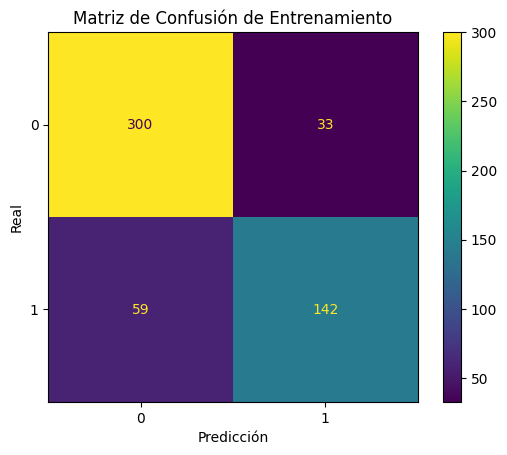

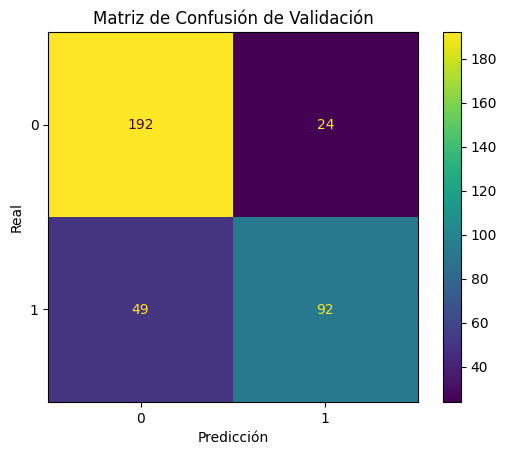

In [301]:
# Grafica la matriz de confusión de entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train)
disp.plot()
plt.title('Matriz de Confusión de Entrenamiento')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Grafica la matriz de confusión de validacion
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_val)
disp.plot()
plt.title('Matriz de Confusión de Validación')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

#### Predicciones con modelo entrenado

Después de haber entrenado el modelo se realizan tres predicciones puntuales con datos aleatorios. Estos se comparan con los datos reales extraidos del subconjunto de validación.

In [302]:
# Obtener la longitud de X_test (y_test tendrá la misma longitud)
n_samples = len(X_val)

random_indices = random.sample(range(n_samples), min(3, n_samples))

# Asegurarse de que los índices seleccionados estén dentro del rango válido
random_indices = [idx for idx in random_indices if idx < n_samples]

# Obtener las muestras de X_val y y_val utilizando los índices seleccionados
three_X_samples = [X_val.iloc[i] for i in random_indices]
three_y_samples = [y_val.iloc[i] for i in random_indices]

# Realizar las predicciones en las muestras seleccionadas
pred_puntuales = [predict_random_forest(forest, sample) for sample in three_X_samples]

# Crear un diccionario con los datos
data = {
    'Real': three_y_samples,
    'Predicción': pred_puntuales
}

# Crear el DataFrame
resultado_df = pd.DataFrame(data)

# Imprimir el DataFrame
print(resultado_df)

   Real  Predicción
0     0           1
1     0           1
2     0           0


## Clasificador KNN

Para más información sobre la implementación favor de consultar el reporte final del reto en la sección **Selección, Configuración y Entrenamiento del Modelo**. El reporte esta ubicado en el repositorio en la carpeta llamada Modelos, junto con las carpetas de cada modelo. El nombre del archivo es: ReporteFinal_Equipo7.pdf. También se puede consultar por medio del siguiente link: https://docs.google.com/document/d/199vDBFCTWJKEMpJC6qNKBOe6Gf4dxnn06aPI6NvIPmA/edit?usp=sharing

Este modelo fue realizado por: Arturo Garza Campuzano, miembro del equipo 7 del curso TC3006C.101.

### Entrenamiento del modelo

Para implementar el modelo KNN sobre la problemática del Titanic se hace uso de una classe llamada KNeightborsClassifier, la cual cuenta con diversos parámetros, pero los más importantes son los siguientes:
1. n_neighbors: número de vecinos (k).
2. metric: metrica usada para el cálculo de la distancia.

¿Cómo se define el valor de k?

No se tiene una regla general, por lo tanto, se procede a probar con un rango de valores establecido por el tamaño del conjunto de datos.

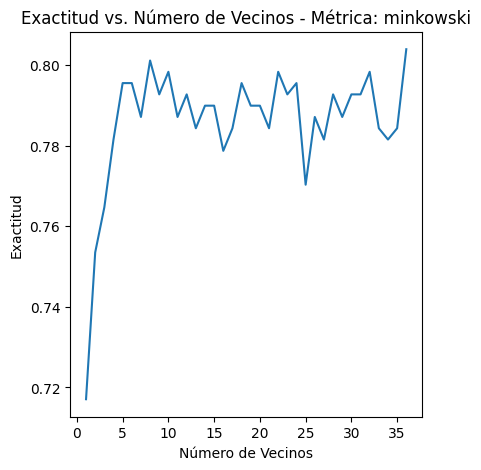

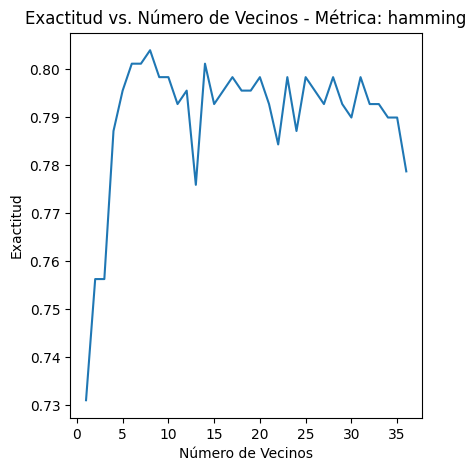

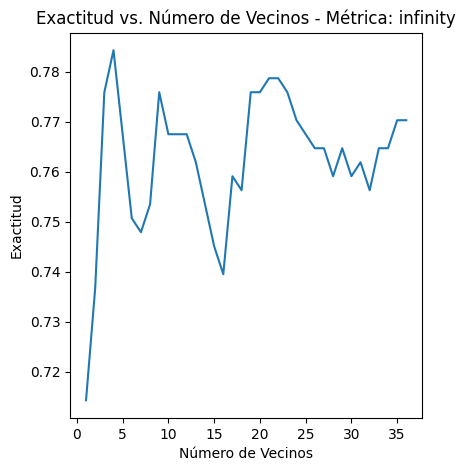

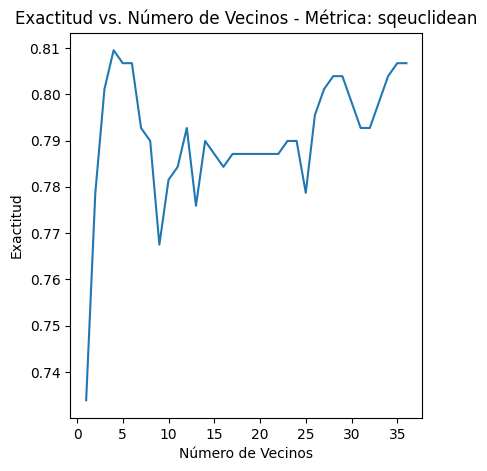

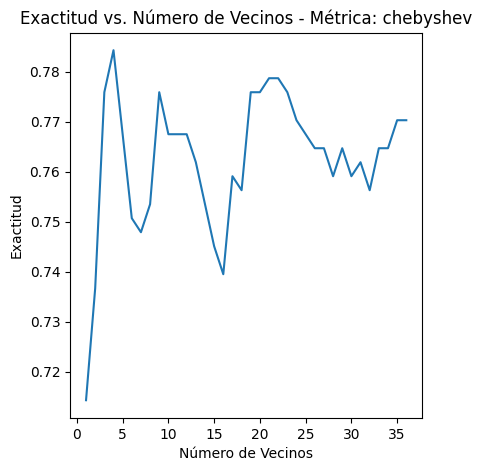

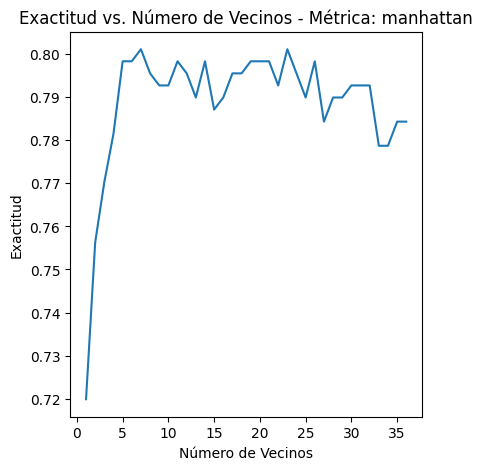

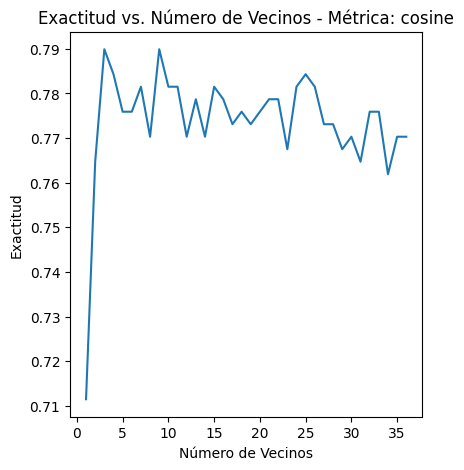

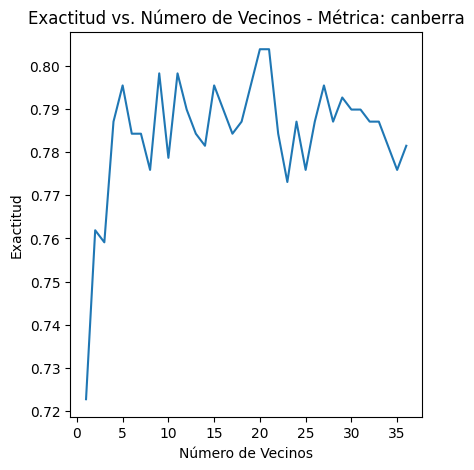

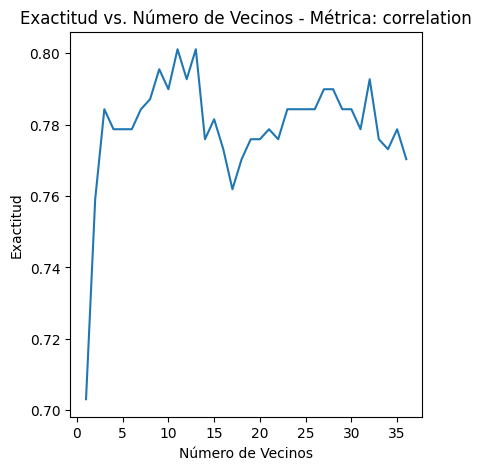

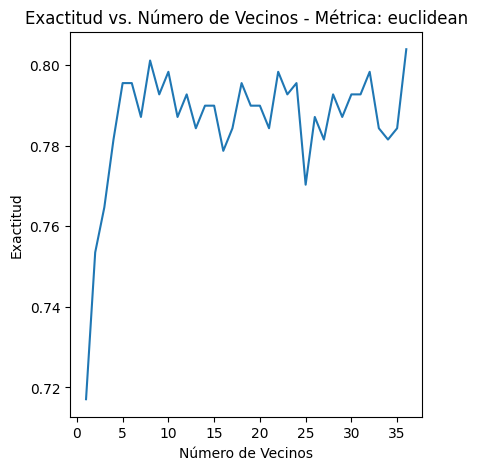

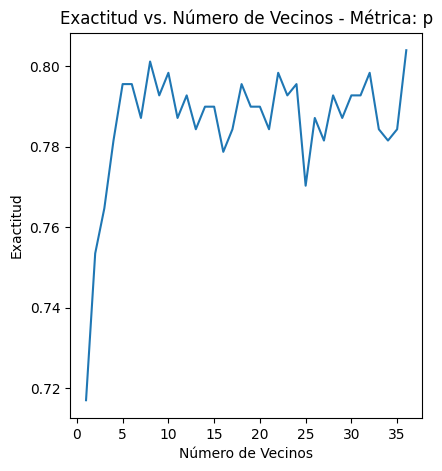

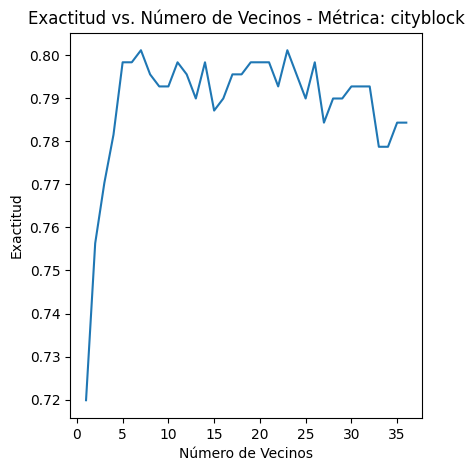

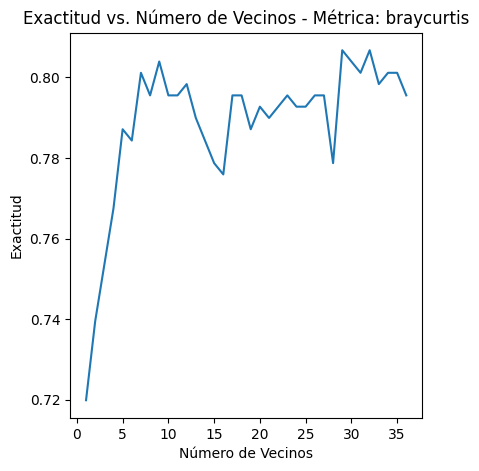

In [303]:
# Definir una funcion para entrenar y evaluar el modelo
def train_and_evaluate_model(X_train, y_train, X_val, y_val, metrica, n_range):
    accuracy_array = []
    train_errors = []
    val_errors = []

    for i in n_range:
        classifier = KNeighborsClassifier(n_neighbors=i, metric=metrica)
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_val)
        # Predecir en el conjunto de entrenamiento y validación
        y_train_pred = classifier.predict(X_train)
        y_val_pred = classifier.predict(X_val)

        accuracy_score_temp = accuracy_score(y_val, y_pred)

        # Calcular el error y almacenarlo
        train_error = 1 - accuracy_score(y_train, y_train_pred)
        val_error = 1 - accuracy_score(y_val, y_val_pred)

        accuracy_array.append(accuracy_score_temp)
        train_errors.append(train_error)
        val_errors.append(val_error)

    return accuracy_array, train_errors, val_errors

# Lista de metricas de distancia a probar
metricas_distancia = ['minkowski', 'hamming', 'infinity', 'sqeuclidean', 'chebyshev', 'manhattan', 'cosine', 'canberra', 'correlation', 'euclidean', 'p', 'cityblock', 'braycurtis']

# Estimación del valor de k
k = int(math.sqrt(len(y_val))*2)
if k % 2 == 0:
  k = k - 1
n_range = list(range(1, k))

# Lista para almacenar los resultados de las métricas
metricas_modelo = []
max_accuracy_dict = {}

# Evaluar el modelo para cada metrica de distancia
for metrica in metricas_distancia:
    accuracy_array, train_errors, val_errors = train_and_evaluate_model(X_train, y_train, X_val, y_val, metrica, n_range)
    metricas_modelo.append([accuracy_array, train_errors, val_errors])

# Procesar los resultados y generar graficos
for metrica, metrica_data in zip(metricas_distancia, metricas_modelo):
    accuracy_scores, train_errors, val_errors = metrica_data

    max_accuracy = max(accuracy_scores)
    best_k = n_range[accuracy_scores.index(max_accuracy)]

    max_accuracy_dict[metrica] = {'max_accuracy': max_accuracy, 'best_k': best_k}

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_range, accuracy_scores)
    plt.xlabel('Número de Vecinos')
    plt.ylabel('Exactitud')
    plt.title(f'Exactitud vs. Número de Vecinos - Métrica: {metrica}')

# Crear un DataFrame a partir del diccionario de resultados
df = pd.DataFrame.from_dict(max_accuracy_dict, orient='index')
df.index.name = 'metric'
df.reset_index(inplace=True)
df.rename(columns={'max_accuracy': 'max_acuraccy', 'best_k': 'k_value'}, inplace=True)


In [304]:
# Imprimir el DataFrame ordenado por resultados sobre validacion
sorted_df = df.sort_values(by=['max_acuraccy', 'k_value'], ascending=[False, True])
sorted_df

,metric,max_acuraccy,k_value
3,sqeuclidean,0.809524,4
12,braycurtis,0.806723,29
1,hamming,0.803922,8
7,canberra,0.803922,20
0,minkowski,0.803922,36
9,euclidean,0.803922,36
10,p,0.803922,36
5,manhattan,0.801120,7
11,cityblock,0.801120,7
8,correlation,0.801120,11


In [305]:
# Mejor configuracion del modelo KNN
best_classifier = KNeighborsClassifier(n_neighbors=4, metric='sqeuclidean')
best_classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='sqeuclidean', n_neighbors=4)

### Análisis de desempeño

#### Métricas de desempeño para subconjuntos de entrenamiento y validación

Para evaluar el desempeño del KNN se prueba con los subconjuntos de entrenamiento y validación para obtener las predicciones. Después se calculan las métricas de desempeño considerando las predicciones de cada subconjunto y los valores esperados.

In [306]:
predictions_val = best_classifier.predict(X_val)
predictions_train = best_classifier.predict(X_train)

# Metricas de desempeno para subconjunto de entrenamiento
confusion_matrix_train, accuracy_score_train, precision_score_train, recall_score_train, f1_score_train = metricas_desempeno(y_train, predictions_train)

# Metricas de desempeno para subconjunto de validacion
confusion_matrix_val, accuracy_score_val, precision_score_val, recall_score_val, f1_score_val = metricas_desempeno(y_val, predictions_val)

# Create a DataFrame to display the metrics
knn_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_score_train, precision_score_train, recall_score_train, f1_score_train],
    'Validation': [accuracy_score_val, precision_score_val, recall_score_val, f1_score_val]
})

knn_metrics_df

,Metric,Train,Validation
0,Accuracy,0.857678,0.809524
1,Precision,0.925170,0.847619
2,Recall,0.676617,0.631206
3,F1 Score,0.781609,0.723577


#### Matriz de confusión

Con motivo de comparar entre las predicciones generadas por el modelo y los valores que debieron de obtenerse se grafica la matriz de confusión para los subconjuntos de entrenamiento y validación.

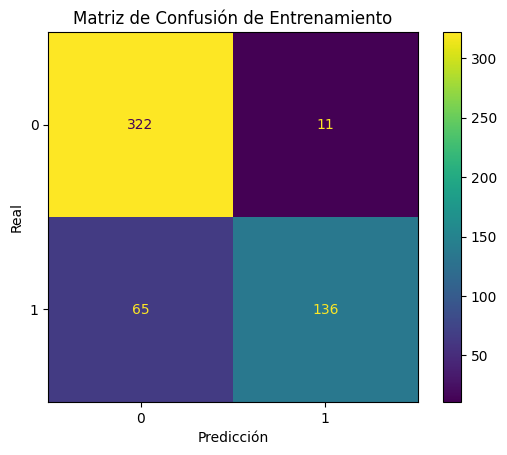

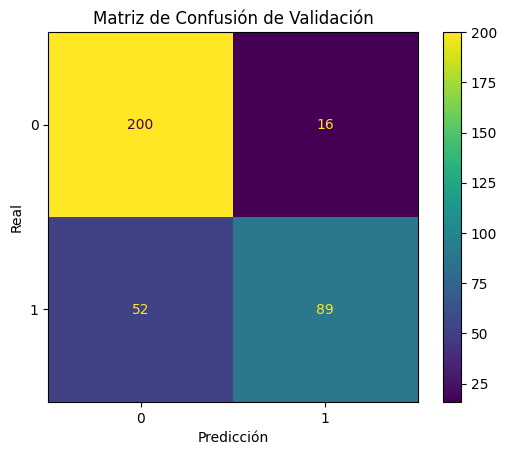

In [307]:
# Grafica la matriz de confusión de entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train)
disp.plot()
plt.title('Matriz de Confusión de Entrenamiento')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Grafica la matriz de confusión de validacion
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_val)
disp.plot()
plt.title('Matriz de Confusión de Validación')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

#### Predicciones con modelo entrenado

Después de haber entrenado el modelo se realizan tres predicciones puntuales con datos aleatorios. Estos se comparan con los datos reales extraidos del subconjunto de validación.

In [308]:
# Obtener la longitud de X_test (y_test tendrá la misma longitud)
n_samples = len(X_val)

# Elegir tres índices aleatorios únicos de X_test
random_indices = random.sample(range(n_samples), min(3, n_samples))

pred_puntuales = best_classifier.predict(three_X_samples)

# Crear un diccionario con los datos
data = {
    'Real': three_y_samples,
    'Prediccion': pred_puntuales
}

# Crear el DataFrame
resultado_df = pd.DataFrame(data)

# Imprimir el DataFrame
resultado_df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


,Real,Prediccion
0,0,1
1,0,0
2,0,0


## Modelo Regresión Logística Multivariable

Para más información sobre la implementación favor de consultar el reporte final del reto en la sección Selección, Configuración y Entrenamiento del Modelo. El reporte esta ubicado en el repositorio en la carpeta llamada Modelos, junto con las carpetas de cada modelo. El nombre del archivo es: ReporteFinal_Equipo7.pdf. También se puede consultar por medio del siguiente link: https://docs.google.com/document/d/199vDBFCTWJKEMpJC6qNKBOe6Gf4dxnn06aPI6NvIPmA/edit?usp=sharing

Elaborado por Marcelo Márquez Murillo - A01720588, para la clase TC3006C.101 del equipo 7

### Entrenamiento del modelo

In [309]:
class LogisticRegression:
    def __init__(self, independent, dependent, num_iters, learning_rate):
        self.dependent = dependent
        self.n = len(dependent)
        # Agregar una columna de unos para que se multiple con el theta0
        self.independent = np.c_[np.ones(self.n), independent]
        self.num_iters = num_iters
        self.learning_rate = learning_rate
        # Crear lista de unos tomando en cuenta el número de variables independientes +1
        self.theta = np.ones(independent.shape[1] + 1)

    def h(self, x_n):
        # Multiplicación de matriz de variables independientes con lista de theta
        # z = theta0*1 + theta1*xi1 + theta2*xi2
        z = np.dot(x_n, self.theta)
        return 1 / (1 + np.exp(-z))

    def fit(self):
        # Iniciar un bucle que se ejecutará durante 'num_iters' iteraciones
        for i in range(self.num_iters):

            # Utilizar el método 'h' para calcular las predicciones de todas las muestras
            # Esto se realiza utilizando la matriz completa de variables independientes
            predictions = self.h(self.independent)

            # Calcular el error (o delta) entre las predicciones y los valores reales (dependientes)
            # El resultado es un vector que contiene el error para cada muestra
            delta = predictions - self.dependent

            # Calcular el gradiente del error con respecto a los parámetros theta
            # Para ello, se realiza el producto punto entre la matriz traspuesta de las variables independientes
            # y el vector de errores, y luego se divide por el número total de muestras (self.n)
            gradient = np.dot(self.independent.T, delta) / self.n

            # Actualizar los valores de los parámetros theta utilizando el gradiente y la tasa de aprendizaje
            # La actualización se realiza en dirección opuesta al gradiente para minimizar la función de costo
            self.theta -= self.learning_rate * gradient

        # Imprimir los valores finales de los parámetros theta
        print(f"Thetas finales: {self.theta}")


    def predict(self, xi):
        # Renglón de X y le agregamos un 1 para theta0
        xi = np.c_[np.ones(xi.shape[0]), xi]
        prob = self.h(xi)
        return np.round(prob)

    @staticmethod
    def evaluate(y_true, y_pred):
        vp = 0
        vn = 0
        fp = 0
        fn = 0

        # Conseguimos matriz de confusión
        n = len(y_true)
        for i in range(n):
            if y_pred[i] == 1:
                if y_true[i] == 1:
                    vp += 1
                else:
                    fp += 1
            else:
                if y_true[i] == 0:
                    vn += 1
                else:
                    fn += 1
        print(f"Model: vp - {vp}, vn - {vn}, fp - {fp}, fn - {fn}")

        # Conseguimos las métricas
        a = round((vp + vn) / (vp + vn + fp + fn), 2)
        p = round(vp / (vp + fp), 2)
        r = round(vp / (vp + fn), 2)
        f1 = round((2 * p * r) / (p + r), 2)
        print(f"Accuracy: {a}, Precision: {p}, Recall: {r}, F1 Score: {f1}")

In [310]:
# Crear modelo
model = LogisticRegression(independent=X_train, dependent=y_train, num_iters=10000, learning_rate=0.05)
# Entrenamos al modelo
model.fit()

Thetas finales: [ 2.126543   -0.77562056 -0.07800413 -2.21049298  0.26391516  0.0673139
 -0.19444621  0.36277953]


### Análisis de desempeño

#### Métricas de desempeño para subconjuntos de entrenamiento y validación

Para evaluar el desempeño del árbol de desición se prueba con los subconjuntos de entrenamiento y validación para obtener las predicciones. Después se calculan las métricas de desempeño considerando las predicciones de cada subconjunto y los valores esperados.

In [311]:
predictions_val = model.predict(X_val)
predictions_train = model.predict(X_train)

# Metricas de desempeno para subconjunto de entrenamiento
confusion_matrix_train, accuracy_score_train, precision_score_train, recall_score_train, f1_score_train = metricas_desempeno(y_train, predictions_train)

# Metricas de desempeno para subconjunto de validacion
confusion_matrix_val, accuracy_score_val, precision_score_val, recall_score_val, f1_score_val = metricas_desempeno(y_val, predictions_val)

# Create a DataFrame to display the metrics
rlm_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_score_train, precision_score_train, recall_score_train, f1_score_train],
    'Validation': [accuracy_score_val, precision_score_val, recall_score_val, f1_score_val]
})

rlm_metrics_df

,Metric,Train,Validation
0,Accuracy,0.794007,0.784314
1,Precision,0.738220,0.738806
2,Recall,0.701493,0.702128
3,F1 Score,0.719388,0.720000


#### Matriz de confusión

Con motivo de comparar entre las predicciones generadas por el modelo y los valores que debieron de obtenerse se grafica la matriz de confusión para los subconjuntos de entrenamiento y validación.

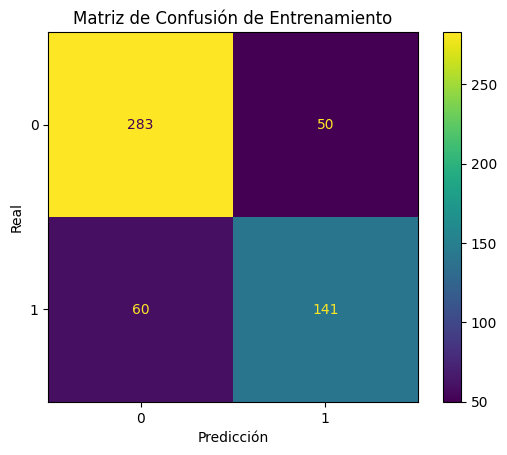

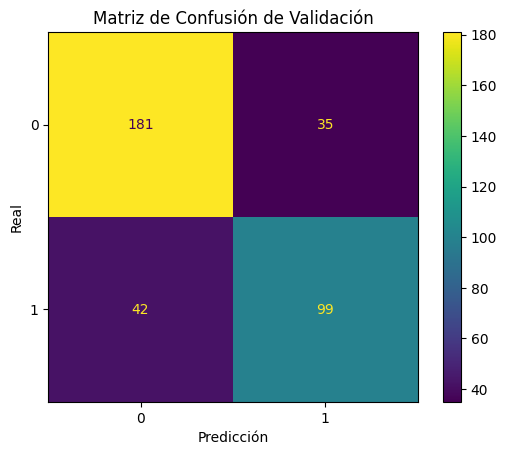

In [312]:
# Grafica la matriz de confusión de entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train)
disp.plot()
plt.title('Matriz de Confusión de Entrenamiento')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Grafica la matriz de confusión de validación
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_val)
disp.plot()
plt.title('Matriz de Confusión de Validación')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

#### Predicciones con modelo entrenado

Después de haber entrenado el modelo se realizan tres predicciones puntuales con datos aleatorios. Estos se comparan con los datos reales extraidos del subconjunto de validación.

In [313]:
# Obtener la longitud de X_test (y_test tendrá la misma longitud)
n_samples = len(X_val)

random_indices = random.sample(range(n_samples), min(3, n_samples))

# Asegurarse de que los índices seleccionados estén dentro del rango válido
random_indices = [idx for idx in random_indices if idx < n_samples]

# Obtener las muestras de X_val y y_val utilizando los índices seleccionados
# three_X_samples = [X_val.iloc[i] for i in random_indices]
# three_y_samples = [y_val.iloc[i] for i in random_indices]

# Realizar las predicciones en las muestras seleccionadas
pred_puntuales = [predict_random_forest(forest, sample) for sample in three_X_samples]

# Crear un diccionario con los datos
data = {
    'Real': three_y_samples,
    'Predicción': pred_puntuales
}

# Crear el DataFrame
resultado_df = pd.DataFrame(data)

# Imprimir el DataFrame
print(resultado_df)

   Real  Predicción
0     0           1
1     0           1
2     0           0


## Selección del mejor modelo

In [314]:
# Agrega una columna "Model" en cada DataFrame para indicar el modelo
rfc_metrics_df['Model'] = 'Random Forest Classifier'
knn_metrics_df['Model'] = 'K-Nearest Neighbor'
rlm_metrics_df['Model'] = 'Regresión Lineal Multivariable'

# Agrega una columna "Subset" en cada DataFrame para indicar el tipo de subconjunto
rfc_metrics_df['Subset'] = 'Train'
knn_metrics_df['Subset'] = 'Train'
rlm_metrics_df['Subset'] = 'Train'

# Concatena los DataFrames en uno solo para el conjunto de entrenamiento
frames_train = [rfc_metrics_df, knn_metrics_df, rlm_metrics_df]
df_train = pd.concat(frames_train, ignore_index=True)

# Reformatea el DataFrame para tener las métricas como columnas
df_train = df_train.pivot(index=['Model', 'Subset'], columns='Metric', values='Train')

# Reinicia el índice
df_train.reset_index(inplace=True)

# Cambia el nombre de las columnas
df_train.columns.name = None

# Ahora, haz lo mismo para el conjunto de validación
# Agrega una columna "Subset" en cada DataFrame para indicar el tipo de subconjunto
rfc_metrics_df['Subset'] = 'Validation'
knn_metrics_df['Subset'] = 'Validation'
rlm_metrics_df['Subset'] = 'Validation'

# Concatena los DataFrames en uno solo para el conjunto de validación
frames_val = [rfc_metrics_df, knn_metrics_df, rlm_metrics_df]
df_val = pd.concat(frames_val, ignore_index=True)

# Reformatea el DataFrame para tener las métricas como columnas
df_val = df_val.pivot(index=['Model', 'Subset'], columns='Metric', values='Validation')

# Reinicia el índice
df_val.reset_index(inplace=True)

# Cambia el nombre de las columnas
df_val.columns.name = None

# Concatenar los DataFrames
result = pd.concat([df_train, df_val], ignore_index=True)

result

,Model,Subset,Accuracy,F1 Score,Precision,Recall
0,K-Nearest Neighbor,Train,0.857678,0.781609,0.925170,0.676617
1,Random Forest Classifier,Train,0.827715,0.755319,0.811429,0.706468
2,Regresión Lineal Multivariable,Train,0.794007,0.719388,0.738220,0.701493
3,K-Nearest Neighbor,Validation,0.809524,0.723577,0.847619,0.631206
4,Random Forest Classifier,Validation,0.795518,0.715953,0.793103,0.652482
5,Regresión Lineal Multivariable,Validation,0.784314,0.720000,0.738806,0.702128


**Observaciones:**
- En los dos subconjuntos, el modelo **K-Nearest Neighbor** tiene el Accuracy más alto tanto en Train (0.857678) como en Validation (0.809524).
- En Validation, el modelo **Regresión Lineal Multivariable** tiene el F1 Score más alto (0.720000), seguido de cerca por **K-Nearest Neighbor** (0.723577).
- En Train, **K-Nearest Neighbor** tiene la Precision más alta (0.925170), y en Validation, **K-Nearest Neighbor** también tiene la Precision más alta (0.847619).
- En Validation, **K-Nearest Neighbor** tiene el Recall más alto (0.631206), y en Train, **Random Forest Classifier** tiene el Recall más alto (0.706468).
